In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn; seaborn.set()
from bs4 import BeautifulSoup
import yfinance as yf

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [2]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 1600 EUR
# ----- ноябрь 2018 - 1550 EUR
# ----- февраль 2019 - 1600 EUR

# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

In [3]:
# Первичный анализ данных и определение базовой цены
#
# Для понимания базовой цены нашего нового продукта Б необходимо
# определить базовую цену существующего продукта А на всем 
# анализируемом периоде, которая упрощенно будет 
# складываться из произв. издержек + маржа/наценка.
#
# Первое слагаемое предоставлено условиями задания, вычисляем маржу,
# используя предоставленные исторические данные по ценам на продукт А.
#
# Т.к. условиями задания не уточнено, считаем, что это среднемес. цены

In [4]:
# Первая версия

dbc = pd.read_excel('cur_oil.xlsx', index_col='Date')
dbc.fillna(method="bfill", inplace=True)
dbc['prod_cost'] = ((dbc['OIL'] * 16) / dbc['EURUSD=X']) + 400

marginA_oct2018 = 1600 / dbc['2018-10']['prod_cost'].mean()
marginA_nov2018 = 1550 / dbc['2018-11']['prod_cost'].mean()
marginA_feb2019 = 1600 / dbc['2019-02']['prod_cost'].mean()

print(marginA_oct2018, marginA_nov2018, marginA_feb2019, sep='\n')

1.1267860656162534
1.266219808955377
1.3349355277998405


In [5]:
# Наценка на продукт А в периодах с разницей в 1 мес. (окт/нояб 2018)
# существенно различаются, версия отметается. Необходим иной порядок 
# расчета производственных издержек
#
# Вторая версия - расчет произв. затрат с использованием скольз. средн.

dbc = pd.read_excel('cur_oil.xlsx', index_col='Date')
dbc.fillna(method="bfill", inplace=True)

roll = dbc.rolling(30, min_periods=1)
dbc['EURUSD_mov_avrg'] = roll.mean()['EURUSD=X']
dbc['OIL_mov_avrg'] = roll.mean()['OIL']

dbc['prod_cost'] = ((dbc['OIL_mov_avrg'] * 16) / dbc['EURUSD_mov_avrg']) + 400

marginA_oct2018 = 1600 / dbc['2018-10']['prod_cost'].mean()
marginA_nov2018 = 1550 / dbc['2018-11']['prod_cost'].mean()
marginA_feb2019 = 1600 / dbc['2019-02']['prod_cost'].mean()

print(marginA_oct2018, marginA_nov2018, marginA_feb2019, sep='\n')

1.1322611793153894
1.1472407185294995
1.3755771534845032


In [6]:
# Теперь разница не такая существенная, версию принимаем.
# Соответственно, формула для расчета базовой цены продукта FCA
# (ежедневный расчет в EUR):
#
# ((Q * OIL_avg / EUR_avg) + Expens.) * margin, 
#
# где Q - норма расходов нефти на производство 1 т ГП, барр.
# OIL_avg - ср. курс 1 барр. нефти за посл. 30 дней, USD/барр.
# EUR_avg - ср. курс 1 EUR к USD за посл. 30 дней, USD
# Expens. - величина пост. затрат, EUR
# margin - размер наценки
#
# Расчет базовой цены продукта А на всем ретро-периоде (интерполяция 
# предоставленных условиями задания данных). С учетом отсутствия
# иных вводных данных и значительно низкими/высокими крайними
# значениями маржи (окт. 2018 - 13 %, фев. 2019 г. - 38 %), 
# экстраполяция значений будет произведена простым копированием
# крайних значений

dbc_mean = dbc.resample('M').mean()
dbc_mean['margin_A'] = list(np.nan for i in range(len(dbc_mean)))
dbc_mean.loc['2018-10-31', 'margin_A'] = marginA_oct2018
dbc_mean.loc['2018-11-30', 'margin_A'] = marginA_nov2018
dbc_mean.loc['2019-02-28', 'margin_A'] = marginA_feb2019

dbc_mean['margin_A'].interpolate(method='linear', limit_direction='both', inplace=True)
dbc['margin_A'] = list(np.nan for i in range(len(dbc)))

for month, val in dbc_mean['margin_A'].to_dict().items():
    for i in dbc.index:
        if (i + pd.offsets.MonthEnd()) == month:
            dbc.loc[i, 'margin_A'] = val

dbc['price_A'] = dbc['prod_cost'] * dbc['margin_A']

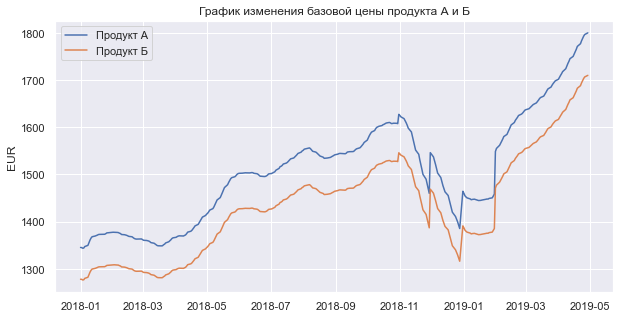

In [7]:
# Расчет цены нового продукта Б по базовой формуле
# с учетом дисконта 5 % от цены продукта А и 
# отображение на графике

dbc['price_B'] = dbc['price_A'] * 0.95

plt.figure(figsize=(10, 5))
plt.plot(dbc['price_A'], label='Продукт А')
plt.plot(dbc['price_B'], label='Продукт Б')
plt.ylabel('EUR')
plt.title("График изменения базовой цены продукта А и Б")
plt.legend()

In [8]:
# Расчет цены DDP для каждого из клиентов (с учетом дисконта 
# 5 % от цены продукта А и расходов на логистику).
# Запись итогов расчетов в отдельные листы эксель-файла

# Выполнение из скрипта (сам скрипт записан в файл ниже)

from script_ddp import ddp
ddp(dbc, customers, EU_LOGISTIC_COST_EUR, CN_LOGISTIC_COST_USD)

In [9]:
%%writefile script_ddp.py
import pandas as pd
import numpy as np

def ddp(dbc, customers, EU, CN):
    with pd.ExcelWriter('clients.xlsx', engine='xlsxwriter') as writer:
        for client in customers:
            df = dbc[['EURUSD=X', 'OIL', 'EURUSD_mov_avrg', 'OIL_mov_avrg', 'prod_cost', 'price_B']].copy()
            if customers[client]['location'] == 'EU':
                df['DDP'] = dbc['price_B'] + EU
            else:
                df['DDP'] = dbc['price_B'] + CN / dbc['EURUSD_mov_avrg']
            df.to_excel(writer, sheet_name=str(client))

Overwriting script_ddp.py


In [10]:
# Расчет стоимости закупки для каждого клиента по вышеуказанной формуле:
# - с учетом объемов закупок; комментарии трактуются так:
# monthly - объем закупок данного клиента в месяц (т в мес.)
# moving_average - средний объем закупок в день за месяц (т в день)
# - с учетом дисконта на объем закупок; скидки за объемы закупок в мес.
# Запись итогов расчетов в отдельные файлы в папке «для клиентов»

# Выполнение из скрипта (сам скрипт записан в файл ниже)

import script_total
script_total.total(customers, discounts)

In [11]:
%%writefile script_total.py
import pandas as pd
import numpy as np
import os

def total(customers, discounts):
    if os.path.exists('для_клиентов/') == False:
        os.mkdir('для_клиентов')
    for client in customers:
        df = pd.read_excel('clients.xlsx', sheet_name=client)
        if customers[client]['comment'] == 'moving_average':
            if (customers[client]['volumes'] * 30) <= 100:
                discount = 1 - float(discounts['up to 100'])
            elif (customers[client]['volumes'] * 30) > 300:
                discount = 1 - float(discounts['300 plus'])
            else:
                discount = 1 - float(discounts['up to 300'])
            df['Total'] = df['DDP'] * customers[client]['volumes'] * discount
        else:
            if customers[client]['volumes'] <= 100:
                discount = 1 - float(discounts['up to 100'])
            elif customers[client]['volumes'] > 300:
                discount = 1 - float(discounts['300 plus'])
            else:
                discount = 1 - float(discounts['up to 300'])
            df['Total'] = df['DDP'] * (customers[client]['volumes'] / 30) * discount
        df.to_excel(f'для_клиентов/{client}.xlsx', index=False)

Overwriting script_total.py


# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

In [12]:
# Вызываемый скрипт является комбинацией двух предыдущих - в нем 
# производится вызов ранее записанных функций (см. ниже). 
# Все заданные условиями задания константы записаны в тело скрипта,
# единственным передаваемым аргументом является словарь с клиентами,
# переменные параметры которых подтягиваются в скрипт.
# 
# Пример:
customers = {
    'ПРИМЕР1':{
        'location':'EU',
        'volumes': 20,
        'comment':'moving_average'
    },
    
    'ПРИМЕР2':{
        'location':'CN',
        'volumes': 1900,
        'comment':'monthly'
    },
    
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}

from script_auto import auto

auto(customers)


In [13]:
%%writefile script_auto.py
import pandas as pd
import numpy as np
import os
from script_ddp import ddp
from script_total import total

def auto(customers):
    dbc = pd.read_excel('cur_oil.xlsx', index_col='Date')
    dbc.fillna(method="bfill", inplace=True)

    roll = dbc.rolling(30, min_periods=1)
    dbc['EURUSD_mov_avrg'] = roll.mean()['EURUSD=X']
    dbc['OIL_mov_avrg'] = roll.mean()['OIL']

    dbc['prod_cost'] = ((dbc['OIL_mov_avrg'] * 16) / dbc['EURUSD_mov_avrg']) + 400

    marginA_oct2018 = 1600 / dbc['2018-10']['prod_cost'].mean()
    marginA_nov2018 = 1550 / dbc['2018-11']['prod_cost'].mean()
    marginA_feb2019 = 1600 / dbc['2019-02']['prod_cost'].mean()
    
    dbc_mean = dbc.resample('M').mean()
    dbc_mean['margin_A'] = list(np.nan for i in range(len(dbc_mean)))
    dbc_mean.loc['2018-10-31', 'margin_A'] = marginA_oct2018
    dbc_mean.loc['2018-11-30', 'margin_A'] = marginA_nov2018
    dbc_mean.loc['2019-02-28', 'margin_A'] = marginA_feb2019

    dbc_mean['margin_A'].interpolate(method='linear', limit_direction='both', inplace=True)
    dbc['margin_A'] = list(np.nan for i in range(len(dbc)))

    for month, val in dbc_mean['margin_A'].to_dict().items():
        for i in dbc.index:
            if (i + pd.offsets.MonthEnd()) == month:
                dbc.loc[i, 'margin_A'] = val

    dbc['price_B'] = dbc['prod_cost'] * dbc['margin_A'] * 0.95
    
    EU_LOGISTIC_COST_EUR = 30 
    CN_LOGISTIC_COST_USD = 130
    discounts = {'up to 100': 0.01, 
                 'up to 300': 0.05, 
                 '300 plus': 0.1}
    
    ddp(dbc, customers, EU_LOGISTIC_COST_EUR, CN_LOGISTIC_COST_USD)
    total(customers, discounts)
    

Overwriting script_auto.py


# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


In [14]:
# Расчет цены DDP (с завода) для клиента из России.
# Скрипт тянет курс валют EUR к рублю с сайта ЦБ РФ, 
# а также котировки нефти и курс EUR/USD с ресурса Yahoo! Finance.
# Вывод - результирующая таблица и ее запись в файл (включает данные
# по последнюю доступную дату с указанных ресурсов)
# Итоговая цена указана в рублях по среднему курсу ЦБ РФ за посл. 30 дн.
# 
# Входной параметр скрипта - количество дней ретро-периода.

from script_rus import rus
rus(days=100).head()

,OIL,EURUSD=X,EURRUB,EURUSD_mov_avrg,OIL_mov_avrg,EURRUB_mov_avrg,prod_cost,price_B(RUB)
2021-07-30,76.330002,1.189300,86.8624,1.189300,76.330002,86.862400,1426.890048,162489.396426
2021-07-29,76.050003,1.184596,86.9173,1.186948,76.190002,86.889850,1427.037751,162557.571069
2021-07-28,74.739998,1.182313,86.9919,1.185403,75.706668,86.923867,1421.852533,162030.318062
2021-07-27,74.480003,1.180777,87.3171,1.184246,75.400002,87.022175,1418.707100,161854.719528
2021-07-23,74.099998,1.177274,86.9227,1.182852,75.140001,87.002280,1416.391125,161553.556266


In [15]:
%%writefile script_rus.py
import pandas as pd
import numpy as np
import os
from datetime import date, timedelta
import requests
from bs4 import BeautifulSoup
import yfinance as yf

def rus(days):
    date_range = [(date.today() - timedelta(days)).strftime('%d.%m.%Y'), date.today().strftime('%d.%m.%Y')]
    url = f'http://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From={date_range[0]}&UniDbQuery.To={date_range[1]}'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'lxml')
    dates = list(map(lambda x: pd.to_datetime(x, format='%d.%m.%Y'), [tag.text for tag in soup.find_all("td")][1::3]))
    course = list(map(lambda x: float('.'.join(x.split(','))), [tag.text for tag in soup.find_all("td")][3::3]))
    eur = pd.DataFrame({'EURRUB': course}, index=dates)
    
    date_range = [(date.today() - timedelta(days)).strftime('%Y-%m-%d'), date.today().strftime('%Y-%m-%d')]
    oil = yf.Ticker("BZ=F").history(start=date_range[0], end=date_range[1])['Close'].rename('OIL')
    usd = yf.Ticker("EURUSD=X").history(start=date_range[0], end=date_range[1])['Close'].rename('EURUSD=X')
    
    dbc = pd.concat([oil, usd, eur], axis=1, join='inner').sort_index(ascending=False)
    
    roll = dbc.rolling(30, min_periods=1)
    dbc['EURUSD_mov_avrg'] = roll.mean()['EURUSD=X']
    dbc['OIL_mov_avrg'] = roll.mean()['OIL']
    dbc['EURRUB_mov_avrg'] = roll.mean()['EURRUB']

    dbc['prod_cost'] = ((dbc['OIL_mov_avrg'] * 16) / dbc['EURUSD_mov_avrg']) + 400

    dbc['price_B(RUB)'] = dbc['prod_cost'] * 1.38 * 0.95 * dbc['EURRUB_mov_avrg']
    dbc.to_excel('rus_client.xlsx')
    
    return dbc
    

Overwriting script_rus.py


# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


In [20]:
# В скрипт интегрирован отлов двух ошибок:
# - отсутствие Интернет-соединения
# - некорректный ввод параметра days
from script_rus_except import rus
rus(days='100')
rus(days=100)

Количество дней ретро-периода указано некорректно, укажите целое число без кавычек.
Ошибка Интернет-подключения, проверьте связь.


In [17]:
%%writefile script_rus_except.py
import pandas as pd
import numpy as np
import os
from datetime import date, timedelta
import requests
from bs4 import BeautifulSoup
import yfinance as yf

def rus(days):
    try:
        date_range = [(date.today() - timedelta(days)).strftime('%d.%m.%Y'), date.today().strftime('%d.%m.%Y')]
    except TypeError:
        print('Количество дней ретро-периода указано некорректно, укажите целое число без кавычек.')
    else:
        url = f'http://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From={date_range[0]}&UniDbQuery.To={date_range[1]}'
    
        try:
            res = requests.get(url)
        except:
            print('Ошибка Интернет-подключения, проверьте связь.')
        else:
            soup = BeautifulSoup(res.text, 'lxml')
            dates = list(map(lambda x: pd.to_datetime(x, format='%d.%m.%Y'), [tag.text for tag in soup.find_all("td")][1::3]))
            course = list(map(lambda x: float('.'.join(x.split(','))), [tag.text for tag in soup.find_all("td")][3::3]))
            eur = pd.DataFrame({'EURRUB': course}, index=dates)

            date_range = [(date.today() - timedelta(days)).strftime('%Y-%m-%d'), date.today().strftime('%Y-%m-%d')]
            oil = yf.Ticker("BZ=F").history(start=date_range[0], end=date_range[1])['Close'].rename('OIL')
            usd = yf.Ticker("EURUSD=X").history(start=date_range[0], end=date_range[1])['Close'].rename('EURUSD=X')

            dbc = pd.concat([oil, usd, eur], axis=1, join='inner').sort_index(ascending=False)

            roll = dbc.rolling(30, min_periods=1)
            dbc['EURUSD_mov_avrg'] = roll.mean()['EURUSD=X']
            dbc['OIL_mov_avrg'] = roll.mean()['OIL']
            dbc['EURRUB_mov_avrg'] = roll.mean()['EURRUB']

            dbc['prod_cost'] = ((dbc['OIL_mov_avrg'] * 16) / dbc['EURUSD_mov_avrg']) + 400

            dbc['price_B(RUB)'] = dbc['prod_cost'] * 1.38 * 0.95 * dbc['EURRUB_mov_avrg']
            dbc.to_excel('rus_client.xlsx')

            return dbc

Overwriting script_rus_except.py


# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [18]:
# В модуль записаны 2 функции, записывающие:
# - всех клиентов в один файл - каждый на отдельном листе
# - всех клиентов в отдельные файлы в папку 'для_клиентов'
#
# Входные параметры:
# - словарь клиенты, установленного заданием формата
# - количестов дней ретро-периода (значения подтягиваются из Интернета)
#
# Важно: вторая функция тянет данные из файла с клиентами 
# (имена текущих клиентов, данные курсов по датам расчетов)

import module_dbc

customers = {
    'Вася В.':{
        'location':'RUS',
        'volumes': 250,
        'comment':'moving_average'
    },
    
    'Леонид Я.':{
        'location':'RUS',
        'volumes': 2300,
        'comment':'monthly'
    },
    
    'Monty':{
        'location':'EU',
        'volumes': 100,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 3050,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 7000,
        'comment': 'monthly'
    }
}

module_dbc.ddp_mod(customers, 100)
module_dbc.total_mod(customers)

In [19]:
%%writefile module_dbc.py
import pandas as pd
import numpy as np
import os
from datetime import date, timedelta
import requests
from bs4 import BeautifulSoup
import yfinance as yf
from script_rus_except import rus

def ddp_mod(customers, days):
    with pd.ExcelWriter('clients.xlsx', engine='xlsxwriter') as writer:
        for client in customers:
            if customers[client]['location'] == 'RUS':
                df = rus(days)
            else:
                date_range = [(date.today() - timedelta(days)).strftime('%Y-%m-%d'), date.today().strftime('%Y-%m-%d')]
                oil = yf.Ticker("BZ=F").history(start=date_range[0], end=date_range[1])['Close'].rename('OIL')
                usd = yf.Ticker("EURUSD=X").history(start=date_range[0], end=date_range[1])['Close'].rename('EURUSD=X')
                dbc = pd.concat([oil, usd], axis=1, join='inner').sort_index(ascending=False)
                roll = dbc.rolling(30, min_periods=1)
                dbc['EURUSD_mov_avrg'] = roll.mean()['EURUSD=X']
                dbc['OIL_mov_avrg'] = roll.mean()['OIL']
                dbc['prod_cost'] = ((dbc['OIL_mov_avrg'] * 16) / dbc['EURUSD_mov_avrg']) + 400
                dbc['price_B'] = dbc['prod_cost'] * 1.38 * 0.95
                df = dbc[['EURUSD=X', 'OIL', 'EURUSD_mov_avrg', 'OIL_mov_avrg', 'prod_cost', 'price_B']].copy()
            if customers[client]['location'] == 'EU':
                df['DDP'] = dbc['price_B'] + 30
            elif customers[client]['location'] == 'CN':
                df['DDP'] = dbc['price_B'] + 130 / dbc['EURUSD_mov_avrg']
            else:
                df['DDP'] = df['price_B(RUB)']
            df.to_excel(writer, sheet_name=str(client))
            
def total_mod(customers):
    discounts = {'up to 100': 0.01, 
                 'up to 300': 0.05, 
                 '300 plus': 0.1}
    if os.path.exists('для_клиентов/') == False:
        os.mkdir('для_клиентов')
    for client in customers:
        df = pd.read_excel('clients.xlsx', sheet_name=client)
        if customers[client]['comment'] == 'moving_average':
            if (customers[client]['volumes'] * 30) <= 100:
                discount = 1 - float(discounts['up to 100'])
            elif (customers[client]['volumes'] * 30) > 300:
                discount = 1 - float(discounts['300 plus'])
            else:
                discount = 1 - float(discounts['up to 300'])
            df['Total'] = df['DDP'] * customers[client]['volumes'] * discount
        else:
            if customers[client]['volumes'] <= 100:
                discount = 1 - float(discounts['up to 100'])
            elif customers[client]['volumes'] > 300:
                discount = 1 - float(discounts['300 plus'])
            else:
                discount = 1 - float(discounts['up to 300'])
            df['Total'] = df['DDP'] * (customers[client]['volumes'] / 30) * discount
        df.to_excel(f'для_клиентов/{client}.xlsx', index=False)

Overwriting module_dbc.py
